<a href="https://colab.research.google.com/github/Leia2000/Bachelorarbeit_Skripte/blob/main/train_SAM_with_TIF_masks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://youtu.be/83tnWs_YBRQ

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Install the required libraries
#SAM
!pip install git+https://github.com/facebookresearch/segment-anything.git
#Transformers
!pip install -q git+https://github.com/huggingface/transformers.git
#Datasets to prepare data and monai if you want to use special loss functions
!pip install datasets
!pip install -q monai
#Patchify to divide large images into smaller patches for training. (Not necessary for smaller images)
!pip install patchify

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile
import os
#from patchify import patchify  #Only to handle large images
import random
from scipy import ndimage

In [ ]:
# Load tiff stack images and masks

#1318 large images as tiff image stack
large_images = tifffile.imread("/content/drive/MyDrive/Bachelorarbeit_Hannes_Grünbeck/No_NaN/masks/really_stacked_images.tif")


In [ ]:
large_images = np.load("/content/drive/MyDrive/Bachelorarbeit_Hannes_Grünbeck/No_NaN/masks/really_stacked_images.tif.npy")

In [ ]:
#1318 large images as tiff image stack
large_masks = tifffile.imread("/content/drive/MyDrive/Bachelorarbeit_Hannes_Grünbeck/No_NaN/masks/mask_stack.tif")


In [ ]:
for i in range(min(5, large_images.shape[0])):  # Display up to 5 slices
    plt.figure()
    plt.title(f"Slice {i+1}")
    plt.imshow(large_images[i], cmap='gray')
    plt.colorbar()
    plt.show()

In [ ]:
large_images.shape

In [ ]:
#Desired patch size for smaller images and step size.
patch_size = 256
step = 256

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Function to display an image and its corresponding mask
def display_image_mask_pair(large_images, large_masks, index):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Display the image
    axes[0].imshow(large_images, cmap='gray')
    axes[0].set_title(f"Image {index}")
    axes[0].axis('off')

    # Display the mask
    axes[1].imshow(large_masks, cmap='gray')
    axes[1].set_title(f"Mask {index}")
    axes[1].axis('off')

    plt.show()

# Number of image-mask pairs to display (adjust as needed)
num_samples_to_display = 5

# Randomly select indices for display
random_indices = np.random.choice(len(large_images), num_samples_to_display, replace=False)

# Display the selected image-mask pairs
for index in random_indices:
    display_image_mask_pair(large_images[index], large_masks[index], index)

# Print some statistics about the masks
print("Mask data type:", large_masks.dtype)
print("Minimum mask value:", large_masks.min())
print("Maximum mask value:", large_masks.max())
print("Number of unique values in masks:", len(np.unique(large_masks)))

# Check for NaN or infinite values in masks
if np.any(np.isnan(large_masks)) or np.any(np.isinf(large_masks)):
    print("Warning: NaN or infinite values found in masks!")

In [ ]:
all_img_patches = []
for img in range(large_images.shape[0]):
    large_image = large_images[img]
    patches_img = patchify(large_image, (patch_size, patch_size), step=step)  #Step=256 for 256 patches means no overlap

    for i in range(patches_img.shape[0]):
        for j in range(patches_img.shape[1]):

            single_patch_img = patches_img[i,j,:,:]
            all_img_patches.append(single_patch_img)

images = np.array(all_img_patches)

#Let us do the same for masks
all_mask_patches = []
for img in range(large_masks.shape[0]):
    large_mask = large_masks[img]
    patches_mask = patchify(large_mask, (patch_size, patch_size), step=step)  #Step=256 for 256 patches means no overlap

    for i in range(patches_mask.shape[0]):
        for j in range(patches_mask.shape[1]):

            single_patch_mask = patches_mask[i,j,:,:]
            single_patch_mask = (single_patch_mask / 255.).astype(np.uint8)
            all_mask_patches.append(single_patch_mask)

masks = np.array(all_mask_patches)

In [ ]:
images.shape

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Function to display an image and its corresponding mask
def display_image_mask_pair(image, mask, index):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Display the image
    axes[0].imshow(image, cmap='gray')
    axes[0].set_title(f"Image {index}")
    axes[0].axis('off')

    # Display the mask
    axes[1].imshow(mask, cmap='gray')
    axes[1].set_title(f"Mask {index}")
    axes[1].axis('off')

    plt.show()

# Number of image-mask pairs to display (adjust as needed)
num_samples_to_display = 5

# Randomly select indices for display
random_indices = np.random.choice(len(images), num_samples_to_display, replace=False)

# Display the selected image-mask pairs
for index in random_indices:
    display_image_mask_pair(images[index], masks[index], index)

# Print some statistics about the masks
print("Mask data type:", masks.dtype)
print("Minimum mask value:", masks.min())
print("Maximum mask value:", masks.max())
print("Number of unique values in masks:", len(np.unique(masks)))

# Check for NaN or infinite values in masks
if np.any(np.isnan(masks)) or np.any(np.isinf(masks)):
    print("Warning: NaN or infinite values found in masks!")

In [ ]:
# Create a list to store the indices of non-empty masks
valid_indices = [i for i, mask in enumerate(masks) if mask.max() != 0]
# Filter the image and mask arrays to keep only the non-empty pairs
filtered_images = images[valid_indices]
filtered_masks = masks[valid_indices]
print("Image shape:", filtered_images.shape)  # e.g., (num_frames, height, width, num_channels)
print("Mask shape:", filtered_masks.shape)

Image shape: (0, 256, 256)
Mask shape: (0, 256, 256)


In [ ]:
all_img_patches = []
for img in range(large_images.shape[0]):
    large_image = large_images[img]

    # Check if the image is already the size of a single patch
    if large_image.shape[0] == patch_size and large_image.shape[1] == patch_size:
        # If yes, append the image directly without patching
        all_img_patches.append(large_image)
    else:
        # If not, proceed with patching
        # patchify expects a 2D or 3D input: (height, width) or (height, width, channels)
        # Assuming large_image is (height, width, channels), proceed directly
        patches_img = patchify(large_image, (patch_size, patch_size, large_images.shape[2]), step=step)

        for i in range(patches_img.shape[0]):
            for j in range(patches_img.shape[1]):
                single_patch_img = patches_img[i, j, 0, :, :, :] # Extract the patch from the 5D output
                all_img_patches.append(single_patch_img)

images = np.array(all_img_patches)

# Apply the same logic to masks, but without channels
all_mask_patches = []
for img in range(large_masks.shape[0]):
    large_mask = large_masks[img]

    if large_mask.shape[0] == patch_size and large_mask.shape[1] == patch_size:
        all_mask_patches.append(large_mask)
    else:
        # patchify for masks should only consider 2 dimensions (height, width)
        patches_mask = patchify(large_mask, (patch_size, patch_size), step=step)

        for i in range(patches_mask.shape[0]):
            for j in range(patches_mask.shape[1]):
                single_patch_mask = patches_mask[i, j, :, :] # Extract the patch from the 4D output
                single_patch_mask = (single_patch_mask / 255.).astype(np.uint8)
                all_mask_patches.append(single_patch_mask)

masks = np.array(all_mask_patches)

In [ ]:
print("Shape der TIF-Datei:", large_masks.shape)

# Eine Ebene der TIF-Datei anzeigen (z. B. die erste Ebene)
plt.imshow(large_masks[0], cmap="gray")  # cmap="gray" für Schwarz-Weiß-Darstellung
plt.title("Erste Ebene der TIF-Datei")
plt.axis("off")
plt.show()

In [ ]:
# Create a list to store the indices of non-empty masks
valid_indices = [i for i, mask in enumerate(masks) if mask.max() != 0]
# Filter the image and mask arrays to keep only the non-empty pairs
filtered_images = images[valid_indices]
filtered_masks = masks[valid_indices]
print("Image shape:", large_images.shape)  # e.g., (num_frames, height, width, num_channels)
print("Mask shape:", large_masks.shape)

Image shape: (1318, 256, 256, 3)
Mask shape: (1318, 256, 256)


In [ ]:
# Graustufen berechnen (Mittelwert über die Kanäle)
grayscale_images = np.mean(large_images, axis=-1)  # Mittelwert entlang der Kanalachse
print("Shape Images:", grayscale_images.shape)  # Sollte (1318, 256, 256) sein
print("Shape Masks:", large_masks.shape)  # Sollte (1318, 256, 256) sein

Shape Images: (1318, 256, 256)
Shape Masks: (1318, 256, 256)


In [ ]:
print("large_masks dtype:", large_masks.dtype)
print("large_masks min:", large_masks.min(), "max:", large_masks.max())

large_masks_normalized = (large_masks / large_masks.max() * 255).astype(np.uint8)
print("large_masks_normalized min:", large_masks_normalized.min(), "max:", large_masks_normalized.max())


large_masks dtype: float32
large_masks min: 0.0 max: 1.0
large_masks_normalized min: 0 max: 255


In [ ]:
from datasets import Dataset
from PIL import Image

# Convert the NumPy arrays to Pillow images and store them in a dictionary
dataset_dict = {
    "image": [Image.fromarray(img) for img in grayscale_images],
    "label": [Image.fromarray(mask) for mask in large_masks_normalized],
}

# Create the dataset using the datasets.Dataset class
dataset = Dataset.from_dict(dataset_dict)

Shape der TIF-Datei: (1318, 256, 256)


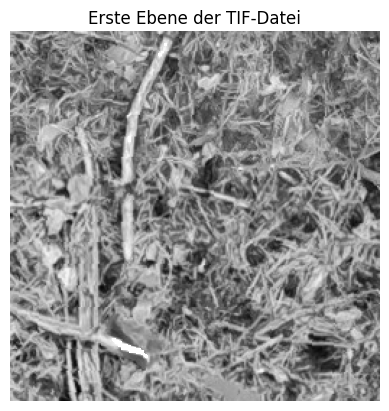

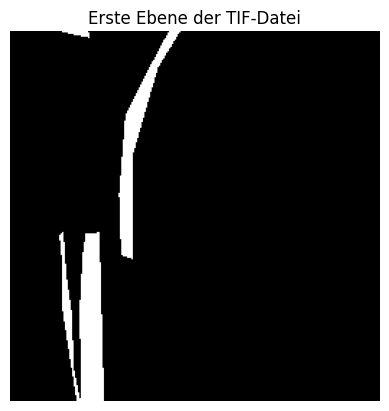

In [ ]:
print("Shape der TIF-Datei:", large_masks.shape)

# Eine Ebene der Image-Datei anzeigen (z. B. die erste Ebene)
plt.imshow(grayscale_images[5], cmap="gray")  # cmap="gray" für Schwarz-Weiß-Darstellung
plt.title("Erste Ebene der TIF-Datei")
plt.axis("off")
plt.show()

# Eine Ebene der TIF-Datei anzeigen (z. B. die erste Ebene)
plt.imshow(large_masks[5], cmap="gray")  # cmap="gray" für Schwarz-Weiß-Darstellung
plt.title("Erste Ebene der TIF-Datei")
plt.axis("off")
plt.show()

In [ ]:
dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 1318
})

Let us make sure out images and masks (labels) are loading appropriately

In [ ]:
img_num = random.randint(0, grayscale_images.shape[0]-1)
example_image = dataset[img_num]["image"]
example_mask = dataset[img_num]["label"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image on the left
axes[0].imshow(np.array(example_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(example_mask, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

NameError: name 'random' is not defined

In [ ]:
#Get bounding boxes from mask.
def get_bounding_box(ground_truth_map):
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

In [ ]:
from torch.utils.data import Dataset

class SAMDataset(Dataset):
  """
  This class is used to create a dataset that serves input images and masks.
  It takes a dataset and a processor as input and overrides the __len__ and __getitem__ methods of the Dataset class.
  """
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    image = item["image"]
    ground_truth_mask = np.array(item["label"])

    # get bounding box prompt
    prompt = get_bounding_box(ground_truth_mask)

    # prepare image and prompt for the model
    inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

    # remove batch dimension which the processor adds by default
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    # add ground truth segmentation
    inputs["ground_truth_mask"] = ground_truth_mask

    return inputs

In [ ]:
# Initialize the processor
from transformers import SamProcessor
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

In [ ]:
from datasets import Dataset
from PIL import Image

# Convert the NumPy arrays to Pillow images and store them in a dictionary
dataset_dict = {
    "image": [Image.fromarray(img).convert("RGB") for img in grayscale_images], # Convert to RGB
    "label": [Image.fromarray(mask) for mask in large_masks_normalized],
}

# Create the dataset using the datasets.Dataset class
dataset = Dataset.from_dict(dataset_dict)

In [ ]:
# Create an instance of the SAMDataset
train_dataset = SAMDataset(dataset=dataset, processor=processor)

In [ ]:
example = train_dataset[0]
for k,v in example.items():
  print(k,v.shape)


pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_boxes torch.Size([1, 4])
ground_truth_mask (256, 256)


In [ ]:
# Create a DataLoader instance for the training dataset
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, drop_last=False)

In [ ]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)

pixel_values torch.Size([2, 3, 1024, 1024])
original_sizes torch.Size([2, 2])
reshaped_input_sizes torch.Size([2, 2])
input_boxes torch.Size([2, 1, 4])
ground_truth_mask torch.Size([2, 256, 256])


In [ ]:
batch["ground_truth_mask"].shape

torch.Size([2, 256, 256])

In [ ]:
# Load the model
from transformers import SamModel
model = SamModel.from_pretrained("facebook/sam-vit-base")

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

config.json:   0%|          | 0.00/6.57k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/375M [00:00<?, ?B/s]

In [ ]:
from torch.optim import Adam
import monai
# Initialize the optimizer and the loss function
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)
#Try DiceFocalLoss, FocalLoss, DiceCELoss
seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

In [ ]:
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize

#Training loop
num_epochs = 10

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()
for epoch in range(num_epochs):
    epoch_losses = []
    for batch in tqdm(train_dataloader):
      # forward pass
      outputs = model(pixel_values=batch["pixel_values"].to(device),
                      input_boxes=batch["input_boxes"].to(device),
                      multimask_output=False)

      # compute loss
      predicted_masks = outputs.pred_masks.squeeze(1)
      ground_truth_masks = batch["ground_truth_mask"].float().to(device)
      loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

      # backward pass (compute gradients of parameters w.r.t. loss)
      optimizer.zero_grad()
      loss.backward()

      # optimize
      optimizer.step()
      epoch_losses.append(loss.item())

    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')

100%|██████████| 659/659 [10:28<00:00,  1.05it/s]


EPOCH: 0
Mean loss: -47296.75991952329


100%|██████████| 659/659 [10:28<00:00,  1.05it/s]


EPOCH: 1
Mean loss: -183572.38274248093


100%|██████████| 659/659 [10:29<00:00,  1.05it/s]


EPOCH: 2
Mean loss: -447520.1387415236


100%|██████████| 659/659 [10:29<00:00,  1.05it/s]


EPOCH: 3
Mean loss: -929521.5620917405


100%|██████████| 659/659 [10:25<00:00,  1.05it/s]


EPOCH: 4
Mean loss: -1722410.999288695


100%|██████████| 659/659 [10:26<00:00,  1.05it/s]


EPOCH: 5
Mean loss: -2899525.1223177873


100%|██████████| 659/659 [10:26<00:00,  1.05it/s]


EPOCH: 6
Mean loss: -4528619.287509484


100%|██████████| 659/659 [10:27<00:00,  1.05it/s]

EPOCH: 7
Mean loss: -6672475.558244025


In [ ]:
# Save the model's state dictionary to a file
torch.save(model.state_dict(), "/content/drive/MyDrive/Bachelorarbeit_Hannes_Grünbeck/Ergebnisse_SAM/test.pth")